# Regression Trees

In this notebook, you will implement a simple regression tree for a one dimensional problem. Using your code, you will explore some basic features of trees and their dependence on their hyperparameters.
Befor we start, just some setup for the notebook.

In [12]:
import itertools
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

The first building block of your regression tree implementation is the loss function. Implement the residual sum of squares loss discussed in the lecture.

In [13]:
def rss_loss(t_left, t_right):
    """Computes the residual sum of squares (RSS) for the two target value vectors t_left and t_right.
    
    To keep this assignment simple, use the mean of the data as the prediction. Based on that,
    this function return the sum of both RSS for t_left and t_right
    """
    # Insert code here!

    # Predictive mean of both nodes
    tl = t_left.mean()
    tr = t_right.mean()
    
    # compute sum of rss in left and right child
    loss = np.sum(np.square(t_left - tl)) + np.sum(np.square(t_right - tr))
    return loss

The next ingredience for your tree is the split function. It takes the current x and t values, and the min_leaf parameter to compute the split with the minimal loss. It returns the index where to split the two arrays and the split value such that every datapoint with x <= x_split falls into the left child, and every observation with x>x_split into the right one. Note that every x value between the largest in the left and the smallest in the right dataset are valid choices. Commonly, the midpoint is chosen, but you can also pick any random point in the interval.

In [3]:
def split(x , t, min_leaf):
    """Computes the optimal split for the data set represented by x and t. """
    
    # Insert code below!
    
    # Loop over all potential partitionings and compute the corresponding loss
    losses = [rss_loss(t[:i],t[i:]) for i in range(min_leaf, len(t) - min_leaf+1)]
    
    # find the split with minimal loss
    best_index = np.argmin(losses) + min_leaf
    
    # simple midpoint
    split_value = (x[best_index-1] + x[best_index])/2
    
    # for slightly randomized trees, one could choose a random split point here.
    split_value = np.random.rand()*(x[best_index] - x[best_index-1]) + x[best_index-1]
    
    #return splitted data
    return best_index, split_value

With everything in place, you can now implement a simple Tree class. The __init__ function just sets up the object. The actual splitting of the data is done in the fit method which should call itself recursively.

In [4]:
class Tree(object):
    """A simple regression tree for 1 dimensional functions"""
    def __init__ (self, min_leaf=1, max_depth=10):
        # hyperparameters
        self.min_leaf=min_leaf
        self.max_depth=max_depth
        # 'pointers' to the two child nodes
        self.subtrees = None
        # if this subtree contains no children, this is the prediction of the leaf
        self.prediction = None
        # if there are two descendents, this is the split value to decide where a given datapoint falls
        self.split_value = None
    
    def fit(self, x, t):
        """partitions the data hierarchically by splitting it into two sets and then recursively fitting a tree on each of these subsets"""
        
        assert x.ndim == 1, "This tree can only fit 1 dimensional regression problems"
        assert x.shape == t.shape, "x and t must have the same number of entries"

        # Insert code below!
        
        # make sure that the x values are in increasing order
        idx = np.argsort(x)
        x = x[idx]
        t = t[idx]
        
        # check if further splitting is allowed
        if len(x)/2 < self.min_leaf or self.max_depth == 0:
            self.prediction = np.mean(t)
            return
        
        #compute the split
        index, self.split_value = split(x,t, self.min_leaf)
        
        #create two subtrees and call their fit method
        l_subtree = Tree(self.min_leaf, self.max_depth-1)
        l_subtree.fit(x[:index], t[:index])
        
        r_subtree = Tree(self.min_leaf, self.max_depth-1)
        r_subtree.fit(x[index:], t[index:])
        
        self.subtrees = [l_subtree, r_subtree]
        
    def predict(self, x):
        """Returns the prediction of the tree for a given input x."""
        # check if this is a leaf and return its prediction if so
        if self.prediction is not None:
            return self.prediction
        # if not, return the prediction of the appropriate child (check split criterion)
        else:
            if x <= self.split_value:
                return self.subtrees[0].predict(x)
            else:
                return self.subtrees[1].predict(x)

        

### Building our first regression Tree

We can now start to grow our first regression trees. We look at a simple regression problem: we draw sample from a one-dimensional function and add some observational noise:

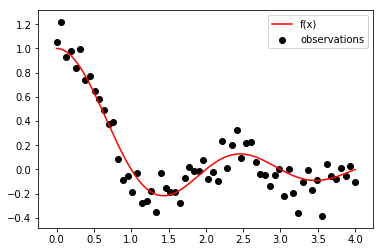

In [5]:
def target_function(x, noise_level=0):
    """convenience function to easily exchange the function to be fitted"""
    return(np.sinc(x) + noise_level*np.random.randn(len(x)))

# defines the x-interval for all following plots
x_interval = [0,4]


def generate_data (N_points, noise = 0):
    """automatically evaluates the target function on equally spaced points and adds some gaussian noise"""
    x_train = np.linspace(x_interval[0],x_interval[1],N_points)
    y_train = target_function(x_train, noise)
    return(x_train, y_train)


N_points=64
noise = 0.1


x_train, y_train = generate_data(N_points, noise)
x_dense = np.linspace(x_interval[0], x_interval[1], 512)
plt.plot(x_dense, target_function(x_dense,0), 'r',label=('f(x)'))
plt.scatter(x_train, y_train, c='black',label='observations')
plt.legend()
plt.show()

Let's first see how the decision tree fits these datapoints when allowed to split into single observations (min_leaf=1):

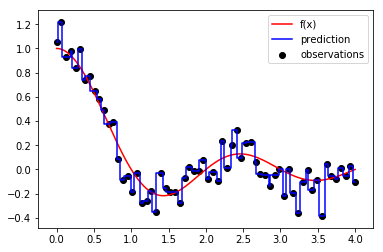

In [6]:
tree = Tree(max_depth=N_points)
tree.fit(x_train, y_train)
plt.plot(x_dense, np.sinc(x_dense), c='r', label=('f(x)'))
plt.scatter(x_train, y_train, c='black', label='observations')

ys = [tree.predict(x) for x in x_dense]
plt.step(x_dense,ys, c='b',label='prediction')
plt.legend(loc=1)
plt.show()

It's not bad, but clearly overfitting to observational noise. You can make that more apperent by increasing the noise. Go back and adjust noise to, say, 0.1! Now the predictions are obviously bad. Keeping multiple data points in a leaf can improve the robustness (decrease variance):

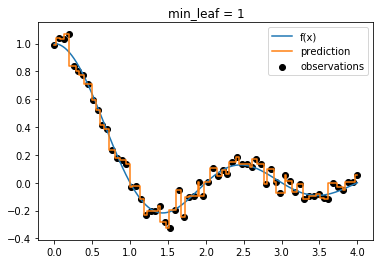

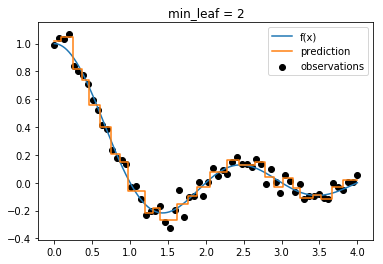

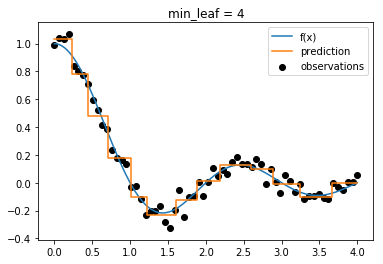

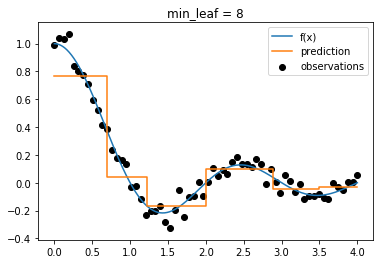

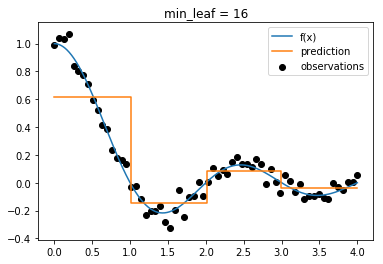

In [7]:
x_train, y_train = generate_data(N_points, 0.05)

for min_leaf in np.logspace(0,np.log2(N_points/4),5, base=2):
    tree = Tree(max_depth=N_points, min_leaf = int(min_leaf))
    tree.fit(x_train,y_train)
    ys = [tree.predict(x) for x in x_dense]
    plt.scatter(x_train, y_train, c='black', label='observations')
    plt.plot(x_dense, np.sinc(x_dense), label=('f(x)'))
    plt.step(x_dense,ys,label='prediction')
    plt.legend(loc=1)
    plt.title('min_leaf = %d'%int(min_leaf))
    plt.show()

Note how 'pooling' observations in the leaves can increase the accuracy of the prediction.

Modify the noise again, and observe how the 'optimal' value of min_leaf will change. Can you see a trend?


# Combining Trees via Bagging to a Random Forest

Now that you have a working regression tree, it is time to study how an ensemble of them performs. For that, you have to fill in some code in the RandomForest class below. It follows the same interface of fit and predict of the Tree class above (and any scikit-learn algorithm).

In the fit method, you have to draw a bootstrap sample (with replacement) of size 'datapoints_per_tree' for each tree in the ensemple. In the predict method, you compute the mean of the individual tree predictions.

In [8]:
class RandomForest(object):
    """A simple Random Forest"""
    def __init__ (self, num_trees = 64, min_leaf=1, max_depth = 32, datapoints_per_tree = 16):
        # initialize hyperparameters
        self.num_trees = num_trees
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.datapoints_per_tree = datapoints_per_tree
        
        # store the individual trees in this list
        self.trees = []
    
    def fit(self, x, t):
        """ takes x and t and fits the specified number of trees to bootstrap samples"""
        self.forest=[]
        # Insert code below!
        for i in range(self.num_trees):
            
            # create bootstrap sample
            indices = np.random.random_integers(len(x_train)-1, size=self.datapoints_per_tree)
            tree = Tree(max_depth=self.max_depth, min_leaf=self.min_leaf)
            tree.fit(x[indices], t[indices])
            self.trees.append(tree)
            
    def predict(self, x):
        # Insert code below!
        tp = [t.predict(x) for t in self.trees]
        return(np.mean(tp))

Executing the next cell will fit a forest to the data and plot the predictions of each tree separately.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: This function is deprecated. Please call randint(1, 63 + 1) instead


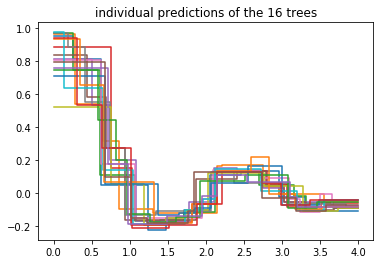

In [9]:
x_train, y_train = generate_data(64, 0.05)
rf = RandomForest(num_trees = 16,min_leaf = 4, datapoints_per_tree = 48)
rf.fit(x_train, y_train)
for i,t in enumerate(rf.trees):
    ys = [t.predict(x) for x in x_dense]
    plt.step(x_dense,ys, label='prediction %d'%i)
    plt.title('individual predictions of the %d trees'%int(min_leaf))
plt.show()

When pooling all the predictions in to a single one, things start to look a lot smoother:

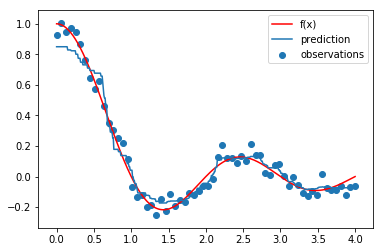

In [10]:
plt.plot(x_dense, target_function(x_dense,0), 'r',label=('f(x)'))
plt.scatter(x_train, y_train, label='observations')
y_forest = [rf.predict(x) for x in x_dense]
plt.plot(x_dense, y_forest, label='prediction')
plt.legend()
plt.show()

Try to adjust the parameters num_trees, min_leaf, data_points_per_tree below to achieve a good overall prediction. Note how each of these parameters influences the prediction

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: This function is deprecated. Please call randint(1, 63 + 1) instead


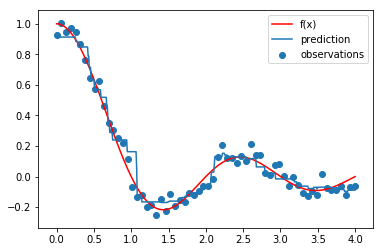

In [11]:
rf = RandomForest(num_trees = 4,min_leaf = 4, datapoints_per_tree = 64)
rf.fit(x_train, y_train)
plt.plot(x_dense, target_function(x_dense,0), 'r',label=('f(x)'))
plt.scatter(x_train, y_train, label='observations')
y_forest = [rf.predict(x) for x in x_dense]
plt.plot(x_dense, y_forest, label='prediction')
plt.legend()
plt.show()

At this point, you should have gained some familiarity with simple regression forests. If you are interested, here are some suggestions of what might interesting to try:
1. If you haven't implement a randomized splitting point (not just the midpoint) in the 'split' function.
2. In the lecture, different 'weak learners' were mentioned. So far, your implementation only predicts a contstant in each leaf. You could implement a simple linear model (scipy.stats.linregress is a good starting point) in the leaves. Note, this would also require to modify the 'split' and the 'squared_loss' function.